In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
from sklearn.feature_extraction.text import CountVectorizer
import re
import urllib3
import urllib3.request
import cv2
import pytesseract
from PIL import Image
import os
import sys
from sklearn.metrics import confusion_matrix
import itertools

# Average number of posts per day (different from total number present in accounts file, we only have one year of data)

In [2]:
brands = ['athenaprocopiou', 'daftcollectionofficial', 'dodobaror', 'emporiosirenuse', 'heidikleinswim',
              'lisamariefernandez', 'loupcharmant', 'miguelinagambaccini', 'muzungusisters', 'zeusndione']

columns = ['username', 'id_post', 'likes_count', 'comment_count', 'taken_at_timestamp']
# reading posts data
posts_data = pd.DataFrame(columns=columns)
for brand in brands:
    posts_data = posts_data.append(pd.read_csv(
        '../EMPORIOSIRENUSE_20173012/' + brand + '/followers data/' + brand + '_followers_posts.csv',
        usecols=columns))

# posts data cleaning
posts_data.drop_duplicates(subset='id_post', inplace=True)
posts_data[['likes_count', 'comment_count']] = posts_data[['likes_count', 'comment_count']].apply(pd.to_numeric)

/home/moreno/anaconda3/envs/datashack/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/moreno/anaconda3/envs/datashack/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
# aggregating posts data to get user features
posts_count = posts_data.groupby(['username']).count()['id_post'].to_frame().reset_index()
posts_count = posts_count.rename(index=str, columns={"id_post": "posts_count"})
posts_count['avg_posts_per_day'] = posts_count['posts_count']/365
print('Max: ' + str(max(posts_count['avg_posts_per_day'])))
posts_count.head()

Max: 42.7424657534


,username,posts_count,avg_posts_per_day
0,0,239,0.654795
1,00006_6,19,0.052055
2,0000gazei,2,0.005479
3,0000pag,8,0.021918
4,001111_18,15,0.041096


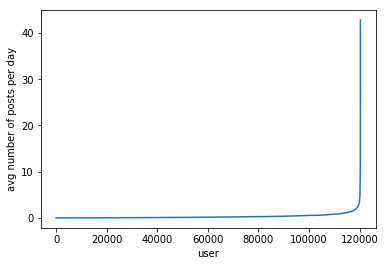

In [9]:
plt.figure()
plt.xlabel('user')
plt.ylabel('avg number of posts per day')
ys = np.sort(posts_count['avg_posts_per_day'].as_matrix())
plt.plot(ys)

This is plot represents the number of posts of each user in the last year, divided by 365. They are in increasing order.

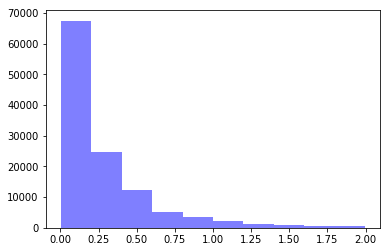

In [13]:
num_bins = 10
n, bins, patches = plt.hist(ys[np.where(ys<2)], num_bins, facecolor='blue', alpha=0.5)
plt.show()

In this histogram you can see the number of users posting between 0 and 2 posts per day. More than 2 is pretty much irrelevant.

In [120]:
ys[-15:]

array([ 13.97260274,  13.97260274,  13.97260274,  15.61643836,
        15.64109589,  16.27671233,  16.91780822,  18.94520548,
        23.72328767,  23.83561644,  24.10136986,  25.24931507,
        27.24383562,  29.39726027,  42.74246575])

In [15]:
posts_count.iloc[np.where(posts_count['avg_posts_per_day'].as_matrix() > 15)]['username']

914       __trends__hunters__
21169        chaneldiorgucci1
21609             checkthetag
24930       cowboyleathershop
36295      fashion_dessert777
40572              gigitropea
59761        laqueen_official
61062         lediamantnoir_d
75606                 mimi9er
79401       mustafayilmaz4399
82251     niallhoran_blessed1
115850              vox_shoes
Name: username, dtype: object

# Total number of posts per hour

In [16]:
def gen_hour_from_timestamp(timestamp):
    return datetime.datetime.fromtimestamp(int(timestamp)).hour

In [17]:
posts_data['taken_at_timestamp'].head().apply(gen_hour_from_timestamp)

0    10
1     0
2    13
3    13
4    21
Name: taken_at_timestamp, dtype: int64

In [18]:
posting_hour = posts_data['taken_at_timestamp'].dropna()
posting_hour = posting_hour.apply(gen_hour_from_timestamp)
posting_hour = posting_hour.as_matrix()

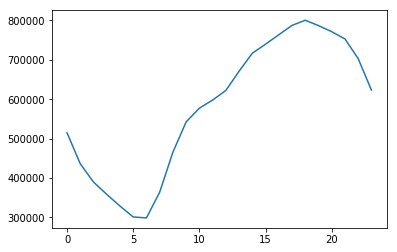

In [19]:
plt.figure()
unique, counts = np.unique(posting_hour, return_counts=True)
plt.plot(unique, counts)

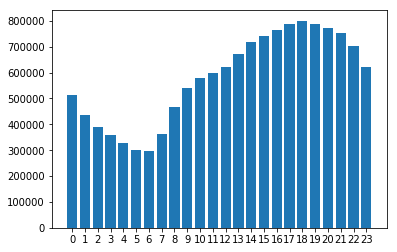

In [20]:
plt.bar(unique, counts)
plt.xticks(unique)
plt.show()

# Now let's repeat the same analisys for the 700 users in already classified

In [3]:
def gen_posts_counts(posts_data):
    posts_count = posts_data.groupby(['username']).count()['id_post'].to_frame().reset_index()
    posts_count = posts_count.rename(index=str, columns={"id_post": "posts_count"})
    posts_count['avg_posts_per_day'] = posts_count['posts_count']/365
    print('Max: ' + str(max(posts_count['avg_posts_per_day'])))
    return posts_count

def gen_posting_hour(posts_data):
    posting_hour = posts_data['taken_at_timestamp'].dropna()
    posting_hour = posting_hour.apply(gen_hour_from_timestamp)
    posting_hour = posting_hour.as_matrix()
    return posting_hour

In [4]:
labels_data = pd.read_csv('../followers_classification/data/700 profiles for claissifier - second round.csv',
                              delimiter=',',
                              usecols=['username', 'consumer', 'retailer', 'others'])
labels_data.head()

,username,consumer,retailer,others
0,nixhus,1,0,0
1,steph_davies,1,0,0
2,gloriavp,1,0,0
3,theajacinto,1,0,0
4,artbydevwoo,1,0,0


In [5]:
labels_posts_data = labels_data.merge(posts_data, on='username')
print(labels_posts_data.shape)
labels_posts_data.head()

(76378, 8)


,username,consumer,retailer,others,comment_count,id_post,likes_count,taken_at_timestamp
0,dies_martis,1,0,0,0.0,1635777297363641957,3.0,1.50922e+09
1,dies_martis,1,0,0,0.0,1618377373349067063,4.0,1.50715e+09
2,dies_martis,1,0,0,0.0,1618376636703549548,6.0,1.50715e+09
3,dies_martis,1,0,0,0.0,1617420557622602585,5.0,1.50703e+09
4,dies_martis,1,0,0,0.0,1604157593562033370,13.0,1.50545e+09


In [34]:
posts_count = gen_posts_counts(labels_posts_data)
posts_count.head()

Max: 9.33698630137


,username,posts_count,avg_posts_per_day
0,25park,1924,5.271233
1,4u2by,29,0.079452
2,__p___w__,441,1.208219
3,_flat_earth_,4,0.010959
4,_louislesouefandco_,200,0.547945


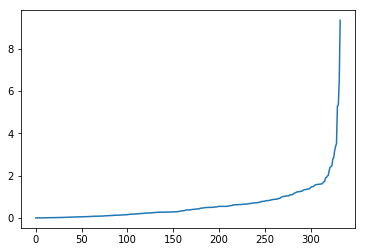

In [37]:
plt.figure()
ys = np.sort(posts_count['avg_posts_per_day'].as_matrix())
plt.plot(ys)

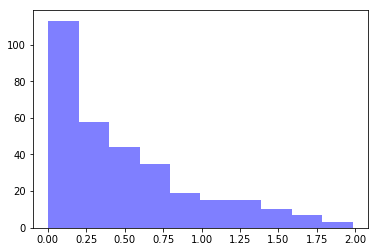

In [39]:
num_bins = 10
n, bins, patches = plt.hist(ys[np.where(ys<2)], num_bins, facecolor='blue', alpha=0.5)
plt.show()

In this histogram you can see the number of classified users posting between 0 and 5 posts per day. More than 5 is pretty much irrelevant.

In [40]:
posting_hour = gen_posting_hour(labels_posts_data)

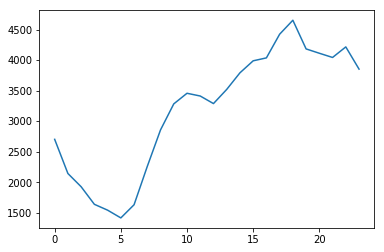

In [41]:
plt.figure()
posting_hour = np.sort(posting_hour)
unique, counts = np.unique(posting_hour, return_counts=True)
plt.plot(unique, counts)

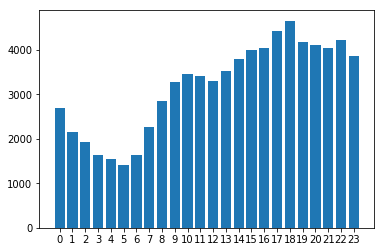

In [42]:
plt.bar(unique, counts)
plt.xticks(unique)
plt.show()

Pretty similar behaviour, let's see if we can distinguish between the various classes

# Let's perform the same analisys on consumers

In [5]:
consumers_posts_data = labels_data.query('consumer == 1').merge(posts_data, on='username')
print(consumers_posts_data.shape)
consumers_posts_data.head()

(36924, 8)


,username,consumer,retailer,others,comment_count,id_post,likes_count,taken_at_timestamp
0,dies_martis,1,0,0,0.0,1635777297363641957,3.0,1.50922e+09
1,dies_martis,1,0,0,0.0,1618377373349067063,4.0,1.50715e+09
2,dies_martis,1,0,0,0.0,1618376636703549548,6.0,1.50715e+09
3,dies_martis,1,0,0,0.0,1617420557622602585,5.0,1.50703e+09
4,dies_martis,1,0,0,0.0,1604157593562033370,13.0,1.50545e+09


In [45]:
posts_count = gen_posts_counts(consumers_posts_data)
posts_count.head()

Max: 5.33698630137


,username,posts_count,avg_posts_per_day
0,__p___w__,441,1.208219
1,_flat_earth_,4,0.010959
2,abelle1010,2,0.005479
3,adva35,103,0.282192
4,agnem__,36,0.098630


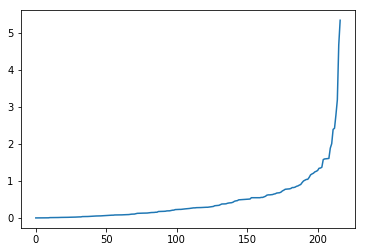

In [46]:
plt.figure()
ys = np.sort(posts_count['avg_posts_per_day'].as_matrix())
plt.plot(ys)

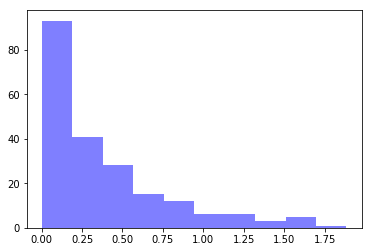

In [47]:
num_bins = 10
n, bins, patches = plt.hist(ys[np.where(ys<2)], num_bins, facecolor='blue', alpha=0.5)
plt.show()

In this histogram you can see the number of **consumers** posting between 0 and 2 posts per day. More than 2 is pretty much irrelevant.

In [48]:
posting_hour = gen_posting_hour(consumers_posts_data)

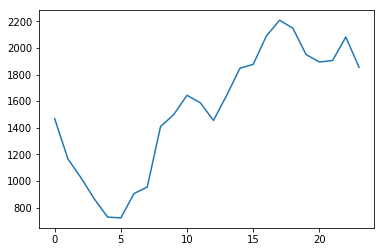

In [49]:
plt.figure()
posting_hour = np.sort(posting_hour)
unique, counts = np.unique(posting_hour, return_counts=True)
plt.plot(unique, counts)

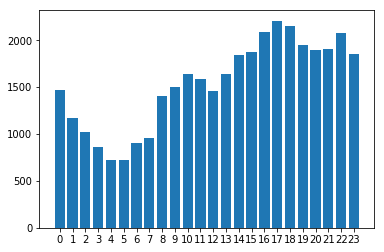

In [50]:
plt.bar(unique, counts)
plt.xticks(unique)
plt.show()

Again pretty similar behaviour, let's do retailers and others

# Retailers and others

In [6]:
others_posts_data = labels_data.query('retailer == 1 or others == 1').merge(posts_data, on='username')
print(others_posts_data.shape)
others_posts_data.head()

(39454, 8)


,username,consumer,retailer,others,comment_count,id_post,likes_count,taken_at_timestamp
0,kenzaeyz,0,0,1,2.0,1641648220171943738,83.0,1509919739
1,kenzaeyz,0,0,1,0.0,1641634314024130306,73.0,1509918081
2,kenzaeyz,0,0,1,5.0,1639431058447466228,111.0,1509655501
3,kenzaeyz,0,0,1,5.0,1638406732034141588,96.0,1509533324
4,kenzaeyz,0,0,1,9.0,1637877093301824855,176.0,1509470186


#### Interestingly enough, even though we have just around 150 users in "others" and "retailer", they have more posts than the consumers, maybe the number of posts is a pretty relevant feature

In [52]:
posts_count = gen_posts_counts(others_posts_data)
posts_count.head()

Max: 6.45205479452


,username,posts_count,avg_posts_per_day
0,25park,1924,5.271233
1,4u2by,29,0.079452
2,_louislesouefandco_,200,0.547945
3,_luluyesyes_,539,1.476712
4,abbeyclancyofficial,100,0.273973


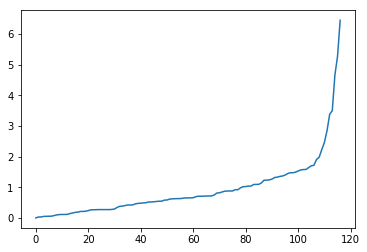

In [53]:
plt.figure()
ys = np.sort(posts_count['avg_posts_per_day'].as_matrix())
plt.plot(ys)

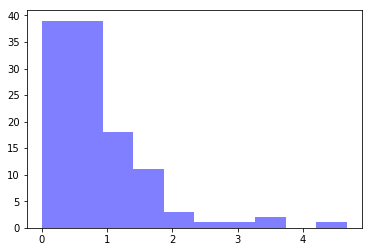

In [55]:
num_bins = 10
n, bins, patches = plt.hist(ys[np.where(ys<5)], num_bins, facecolor='blue', alpha=0.5)
plt.show()

It looks like retailers and others tend to post more often than consumers! The scale of this histogram is different than before, the others had a maximum of 2 posts per day on the x axis, here 5 was chosen to better represent the distribution.

In [56]:
posting_hour = gen_posting_hour(consumers_posts_data)

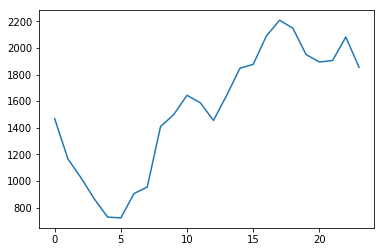

In [57]:
plt.figure()
unique, counts = np.unique(posting_hour, return_counts=True)
plt.plot(unique, counts)

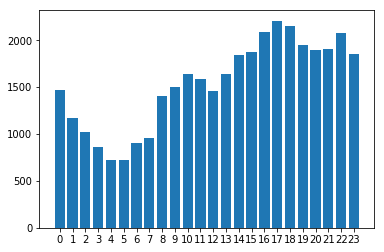

In [58]:
plt.bar(unique, counts)
plt.xticks(unique)
plt.show()

# Just retailers

In [7]:
retailers_posts_data = labels_data.query('retailer == 1').merge(posts_data, on='username')
print(retailers_posts_data.shape)
retailers_posts_data.head()

(8011, 8)


,username,consumer,retailer,others,comment_count,id_post,likes_count,taken_at_timestamp
0,tamarlandau_tml,0,1,0,1.0,1644802635617603488,26.0,1510295775
1,tamarlandau_tml,0,1,0,1.0,1644030760293638140,35.0,1510203760
2,tamarlandau_tml,0,1,0,0.0,1643345719183902785,29.0,1510122097
3,tamarlandau_tml,0,1,0,7.0,1642588797325300378,59.0,1510031865
4,tamarlandau_tml,0,1,0,2.0,1641852923281312928,33.0,1509944142


In [61]:
# aggregating posts data to get user features
posts_count = gen_posts_counts(retailers_posts_data)
posts_count.head()

Max: 6.45205479452


,username,posts_count,avg_posts_per_day
0,aranaz_dxb,260,0.712329
1,cabanashow,97,0.265753
2,claretshowroom,572,1.567123
3,ekaterinipietri,182,0.498630
4,fashionbank_online,310,0.849315


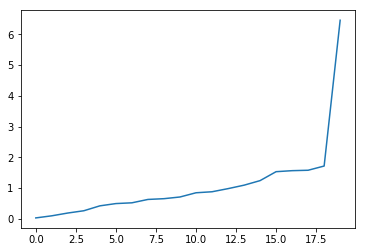

In [62]:
plt.figure()
ys = np.sort(posts_count['avg_posts_per_day'].as_matrix())
plt.plot(ys)

In [63]:
posting_hour = gen_posting_hour(retailers_posts_data)

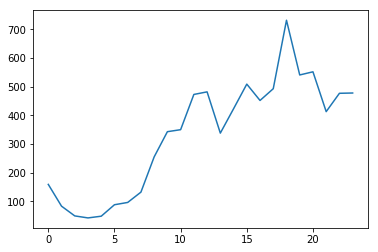

In [64]:
plt.figure()
unique, counts = np.unique(posting_hour, return_counts=True)
plt.plot(unique, counts)

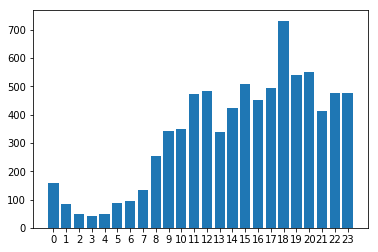

In [65]:
plt.bar(unique, counts)
plt.xticks(unique)
plt.show()

# Lets look for a common language in the bios of retailers and others

In [8]:
def clean_bios(bio):
    bio = bio.replace('\\x', '<')
    bio = bio.replace('\\n', '')
    bio = bio.replace('\\r', '')
    bio = bio.replace('\\', '')
    bio = bio.replace('b\'', '')
    #this last one removes emojis
    bio = re.sub('<\w\w', '', bio)
    return bio

In [9]:
brands = ['athenaprocopiou', 'daftcollectionofficial', 'dodobaror', 'emporiosirenuse', 'heidikleinswim',
              'lisamariefernandez', 'loupcharmant', 'miguelinagambaccini', 'muzungusisters', 'zeusndione']
# reading posts data
followers_data = pd.DataFrame()
for brand in brands:
    followers_data = followers_data.append(pd.read_csv(
        '../EMPORIOSIRENUSE_20173012/' + brand + '/followers data/' + brand + '_followers_accounts.csv'))
followers_data['biography'] = followers_data['biography'].fillna('BIO_PLACEHOLDER')
followers_data['biography'] = followers_data['biography'].apply(clean_bios)
followers_data[['followers_count', 'following_count']] = followers_data[['followers_count', 'following_count']].apply(pd.to_numeric)
followers_data.drop_duplicates(subset='username', inplace=True, keep='last')
followers_data['ff_ratio'] = followers_data['followers_count']
#followers_data['ff_ratio'] = followers_data['ff_ratio'].div((followers_data.following_count + 100), axis=0)
followers_data['ff_ratio'] = followers_data['ff_ratio'].div((followers_data.following_count), axis=0)
followers_data.head()


,id_user,username,profile_pic_url,followers_count,following_count,num_posts,biography,isPrivate,ff_ratio
0,9659,k8therine,https://scontent-mxp1-1.cdninstagram.com/t51.2...,255,729,37,n c h a n t enchnte',True,0.349794
1,75438,ivvyhu,https://scontent-mxp1-1.cdninstagram.com/t51.2...,977,920,1186,',True,1.061957
2,96713,theplimmer,https://scontent-mxp1-1.cdninstagram.com/t51.2...,480,913,1152,I like to see people laugh',False,0.525739
3,99784,jaceq,https://scontent-mxp1-1.cdninstagram.com/t51.2...,38,695,5,BIO_PLACEHOLDER,True,0.054676
5,123581,abigailhofbauer,https://scontent-mxp1-1.cdninstagram.com/t51.2...,1438,1475,967,BIO_PLACEHOLDER,False,0.974915


In [10]:
others_account_data = labels_data.query('retailer == 1 or others == 1').merge(followers_data, on='username')
others_account_data.head()

,username,consumer,retailer,others,id_user,profile_pic_url,followers_count,following_count,num_posts,biography,isPrivate,ff_ratio
0,kenzaeyz,0,0,1,2241410686,https://scontent-mxp1-1.cdninstagram.com/t51.2...,1838,3069,735,International Communications & MarketingP.R. A...,False,0.598892
1,aleorland,0,0,1,204891155,https://instagram.fprg2-1.fna.fbcdn.net/t51.28...,36735,890,1645,alejandra.amoros@gmail.com',False,41.275281
2,thegreedysprout,0,0,1,928853515,https://scontent-sin6-1.cdninstagram.com/t51.2...,572,830,679,plants all animals Vegan baking blogger Juni...,False,0.689157
3,thelouloves,0,0,1,2023642053,https://scontent-mxp1-1.cdninstagram.com/t51.2...,240,459,291,Brit Blogger 32 Sydney | AUS asklouloves@gm...,False,0.522876
4,thewearnecessities,0,0,1,2241307019,https://scontent-mxp1-1.cdninstagram.com/t51.2...,27121,2277,7441,My online scrapbook of all things fashion!! Fo...,False,11.910848


In [11]:
vectorizer = CountVectorizer(min_df=3, stop_words=['and', 'or', 'before', 'a', 'an', 'the', 'bio', 'is', 'all', 'to', 'for', 'by', 'in', 'of', 'we', 'our', 'at'])
x = vectorizer.fit_transform(others_account_data['biography'])
reverse_voc = {y:x for x,y in vectorizer.vocabulary_.items()}
x.shape

(146, 91)

In [12]:
counts = np.squeeze(np.asarray(x.sum(axis=0)))
sorted_idx = np.flip(np.argsort(counts), axis=0)
names = [reverse_voc[idx] for idx in sorted_idx]
names

['com',
 'fashion',
 'shop',
 'with',
 'de',
 'gmail',
 'new',
 'info',
 'shipping',
 'online',
 'jewelry',
 'bio_placeholder',
 'from',
 'luxury',
 'us',
 'world',
 'brand',
 'handmade',
 'inspired',
 'beautiful',
 'design',
 'on',
 'la',
 'worldwide',
 'york',
 'modern',
 'official',
 'london',
 'love',
 'out',
 'your',
 'global',
 'spain',
 'store',
 'best',
 'beauty',
 'women',
 'www',
 'email',
 'http',
 'lover',
 'designers',
 'city',
 'boutique',
 'jewellery',
 'accessories',
 'lifestyle',
 'made',
 'style',
 'what',
 'madrid',
 'that',
 'quality',
 'pr',
 'only',
 'now',
 'via',
 'my',
 'vogue',
 'based',
 'curated',
 'art',
 'up',
 'agency',
 'blog',
 'bohemian',
 'unique',
 'things',
 'account',
 'wholesale',
 'clothing',
 'sydney',
 'you',
 'swimwear',
 'swim',
 'magazine',
 'label',
 'make',
 'kids',
 'me',
 'it',
 'insider',
 'pieces',
 'handcrafted',
 'retail',
 'sales',
 'shoes',
 'sisters',
 'dm',
 'designer',
 '16']

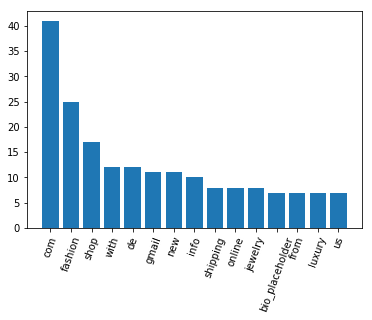

In [13]:
ind = range(15)
plt.bar(ind, counts[sorted_idx[:15]])
plt.xticks(rotation=70)
plt.xticks(ind, names[:15])
plt.show()

These are the most used words in the bios of retailers and others. Let's now see how different it is wrt consumers ones

In [14]:
consumers_account_data = labels_data.query('consumer == 1').merge(followers_data, on='username')
consumers_account_data.head()

,username,consumer,retailer,others,id_user,profile_pic_url,followers_count,following_count,num_posts,biography,isPrivate,ff_ratio
0,nixhus,1,0,0,255110106,https://scontent-mxp1-1.cdninstagram.com/t51.2...,150,339,691,BIO_PLACEHOLDER,True,0.442478
1,steph_davies,1,0,0,36203661,https://scontent-sin6-1.cdninstagram.com/t51.2...,432,1312,537,Liverpool | 23',True,0.329268
2,gloriavp,1,0,0,2319070,https://scontent-hkg3-1.cdninstagram.com/t51.2...,1857,2678,1242,"Fashion Designer who loves lifestyle, homedeco...",False,0.693428
3,theajacinto,1,0,0,8956425,https://scontent-sin6-1.cdninstagram.com/t51.2...,764,1667,366,the official Andy and Alfie fan page',True,0.458308
4,artbydevwoo,1,0,0,14255411,https://instagram.fprg2-1.fna.fbcdn.net/t51.28...,888,2552,91,BIO_PLACEHOLDER,True,0.347962


In [15]:
vectorizer = CountVectorizer(min_df=3, stop_words=['and', 'or', 'before', 'a', 'an', 'the', 'bio', 'is', 'all', 'to', 'for', 'by', 'in', 'of', 'we', 'our', 'at', 'my', 'be', 'bio_placeholder'])
x = vectorizer.fit_transform(consumers_account_data['biography'])
reverse_voc = {y:x for x,y in vectorizer.vocabulary_.items()}

In [16]:
counts = np.squeeze(np.asarray(x.sum(axis=0)))
sorted_idx = np.flip(np.argsort(np.squeeze(np.asarray(x.sum(axis=0)))), axis=0)
names = [reverse_voc[idx] for idx in sorted_idx]
names

['fashion',
 'com',
 'life',
 'love',
 'me',
 'director',
 'designer',
 'london',
 'founder',
 'gmail',
 'with',
 'creative',
 'lover',
 'travel',
 'stylist',
 'you',
 'de',
 'follow',
 'make',
 'your',
 'time',
 'family',
 'interior',
 'it',
 'from',
 'lifestyle',
 'mother',
 'design',
 'are',
 'food',
 'living',
 'good',
 'music',
 'art',
 'artist',
 'world',
 'co',
 'on',
 'have',
 'fun',
 'pictures',
 'style',
 'things',
 'twitter',
 'everything',
 'one',
 'friends',
 'may',
 'blog',
 'model',
 'more',
 'mum',
 'mummy',
 'buyer',
 'based',
 'consultant',
 'do',
 'fitness',
 'writer',
 'always',
 'snapchat',
 'born',
 '16',
 'll',
 'new',
 'manager',
 'photos',
 'magazine',
 'nyc',
 'live',
 'la',
 'no',
 'miami',
 'blogger',
 'coffee',
 'ceo',
 'made',
 'loving',
 'brand',
 'marketing',
 'shop',
 'bitch',
 'best',
 'day',
 'beauty',
 'mind',
 'mommy',
 'adventures',
 '22',
 'wife',
 'vintage',
 'visual',
 'instagram',
 'info',
 'hotmail',
 'sharing',
 'less',
 'real',
 'not',
 'fre

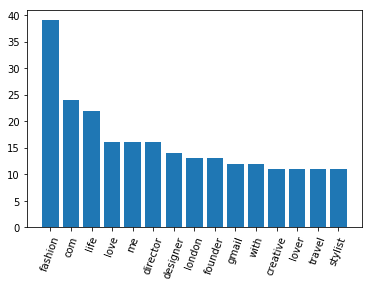

In [17]:
ind = range(15)
plt.bar(ind, counts[sorted_idx[:15]])
plt.xticks(rotation=70)
plt.xticks(ind, names[:15])
plt.show()

It looks fairly different, I'll try to use the numeber of words in these two vocabularies as a feature, let's see what comes out

# Followers to following ratio

### Consumers

avg value:4.03492038631112


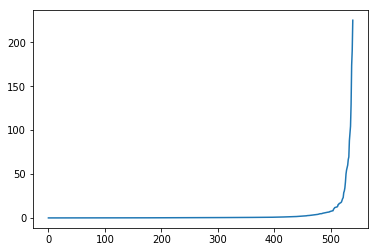

In [18]:
plt.figure()
ys = np.sort(consumers_account_data['ff_ratio'].as_matrix())
plt.plot(ys)
print('avg value:' + str(np.mean(ys)))

avg value:24.23064823069782


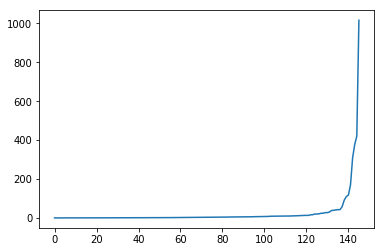

In [19]:
plt.figure()
ys = np.sort(others_account_data['ff_ratio'].as_matrix())
plt.plot(ys)
print('avg value:' + str(np.mean(ys)))

# Profile pics

In [130]:
def download_pic(username, url, path):
    try:
        urllib.request.urlretrieve(url, '../followers_classification/data/profile_pics/' + path + '/' + username + '.jpg')
        print(username + ': ' + url)
    except (urllib.error.HTTPError, urllib.error.URLError)  as err:
        print(username + ' not found at ' + url)

In [ ]:
consumers_account_data.apply(lambda row: download_pic(row['username'], row['profile_pic_url'], 'consumers'), axis=1)
others_account_data.apply(lambda row: download_pic(row['username'], row['profile_pic_url'], 'others'), axis=1)

nixhus: https://scontent-mxp1-1.cdninstagram.com/t51.2885-19/10809579_1546172805639557_1849636847_a.jpg
steph_davies not found at https://scontent-sin6-1.cdninstagram.com/t51.2885-19/s150x150/22794528_1303136496480298_4915779667308314624_n.jpg
gloriavp: https://scontent-hkg3-1.cdninstagram.com/t51.2885-19/s150x150/16906865_1893687914211421_1161988949367848960_a.jpg
theajacinto: https://scontent-sin6-1.cdninstagram.com/t51.2885-19/s150x150/11333373_1613570272265702_175963099_a.jpg
artbydevwoo: https://instagram.fprg2-1.fna.fbcdn.net/t51.2885-19/11377878_1610239649253313_1689300543_a.jpg
ndeosrnenney: https://scontent-iad3-1.cdninstagram.com/t51.2885-19/10895473_1510159419208895_541429301_a.jpg
dies_martis: https://scontent-mxp1-1.cdninstagram.com/t51.2885-19/s150x150/12327970_1682833782003161_869984426_a.jpg
itssara_sh not found at https://scontent-sjc2-1.cdninstagram.com/t51.2885-19/s150x150/13534404_1794208610865782_933390386_a.jpg
kaitjordmitch: https://scontent-mxp1-1.cdninstagram.c

bepivalerio: https://scontent-sea1-1.cdninstagram.com/t51.2885-19/11008225_1567070186867261_2110460855_a.jpg
giusi_zarra: https://scontent-mxp1-1.cdninstagram.com/t51.2885-19/s150x150/18580495_1379743192102467_8045089403200077824_a.jpg
rachelingram14: https://scontent-hkg3-1.cdninstagram.com/t51.2885-19/s150x150/21434215_822381324595421_7382515454260019200_a.jpg
oremasylson: https://instagram.fprg2-1.fna.fbcdn.net/t51.2885-19/10832171_315821531940834_1078383916_a.jpg
ronyizhar: https://instagram.fprg2-1.fna.fbcdn.net/t51.2885-19/s150x150/11426662_433374790203604_1005162613_a.jpg
get_itwhileucan: https://scontent-iad3-1.cdninstagram.com/t51.2885-19/s150x150/18513280_1673556436286997_2076354810575060992_a.jpg
batelbider2420: https://instagram.fprg2-1.fna.fbcdn.net/t51.2885-19/s150x150/13584022_1763638503907793_629588656_a.jpg
artworld_problems: https://scontent-mxp1-1.cdninstagram.com/t51.2885-19/s150x150/12237402_1636661509950436_48261048_a.jpg
ritacolomba not found at https://scontent-

mmmsarap: https://scontent-iad3-1.cdninstagram.com/t51.2885-19/s150x150/14624827_1216846211687051_4052399895447863296_a.jpg
nancykladixifita: https://scontent-mxp1-1.cdninstagram.com/t51.2885-19/s150x150/12317835_197644723911438_2060069793_a.jpg
salmamerchantr: https://scontent-sin6-1.cdninstagram.com/t51.2885-19/11378160_734880639973654_221066189_a.jpg
kate_hallett: https://instagram.fprg2-1.fna.fbcdn.net/t51.2885-19/s150x150/18160987_820450434775978_3290799642932936704_a.jpg
miniblondie not found at https://scontent-sin6-1.cdninstagram.com/t51.2885-19/s150x150/22429567_533280367016727_3463302520430919680_n.jpg
sandyluxury: https://scontent-mxp1-1.cdninstagram.com/t51.2885-19/s150x150/12822269_228825267467055_1229650788_a.jpg
shniz1988: https://instagram.fprg2-1.fna.fbcdn.net/t51.2885-19/891384_895748567120447_372242471_a.jpg
rockychristina: https://scontent-mxp1-1.cdninstagram.com/t51.2885-19/10890817_1596212293933315_2011664566_a.jpg
maferdzv12: https://scontent-iad3-1.cdninstagram.

sunsulimanov not found at https://instagram.fprg2-1.fna.fbcdn.net/t51.2885-19/s150x150/22860313_224642424739228_4197430890810310656_n.jpg
lulagogopro: https://scontent-mxp1-1.cdninstagram.com/t51.2885-19/s150x150/14719291_1705560629685786_5001851280071589888_a.jpg
lannahowmanx: https://scontent-iad3-1.cdninstagram.com/t51.2885-19/10608137_515686398561406_1364348082_a.jpg
assiraooper: https://instagram.fprg2-1.fna.fbcdn.net/t51.2885-19/10387949_335524976656150_1064046371_a.jpg
aidenustinu: https://scontent-iad3-1.cdninstagram.com/t51.2885-19/10838351_1533783760194648_317569620_a.jpg
eyesoulate: https://instagram.fprg2-1.fna.fbcdn.net/t51.2885-19/11015507_1555638831354797_839039485_a.jpg
misosaid: https://scontent-mxp1-1.cdninstagram.com/t51.2885-19/s150x150/16583571_198006634010719_8402994705922523136_a.jpg
earthloveschaos not found at https://scontent-mxp1-1.cdninstagram.com/t51.2885-19/s150x150/13739625_1048566715199230_1568577456_a.jpg
nadinetteab: https://scontent-sin6-1.cdninstagra

kelly_n_1991 not found at https://instagram.fprg2-1.fna.fbcdn.net/t51.2885-19/11252824_1588238641456676_2124432028_a.jpg
anithoula: https://scontent-mxp1-1.cdninstagram.com/t51.2885-19/s150x150/14288178_368837770171211_7489653696926580736_a.jpg
nawara_76: https://instagram.fprg2-1.fna.fbcdn.net/t51.2885-19/10570227_1513556788859522_646664248_a.jpg
lillianmano: https://scontent-sit4-1.cdninstagram.com/t51.2885-19/11379279_1113442602017548_530027215_a.jpg
steph_ssmith: https://scontent-mxp1-1.cdninstagram.com/t51.2885-19/s150x150/16583447_1202190309849570_1872195043398254592_a.jpg
federichella69: https://scontent-mxp1-1.cdninstagram.com/t51.2885-19/s150x150/12930901_1079707158748782_733590170_a.jpg
lorrddwade: https://scontent-hkg3-1.cdninstagram.com/t51.2885-19/s150x150/11375322_852685411467083_1949285604_a.jpg
alexandrakoumentakou not found at https://scontent-mxp1-1.cdninstagram.com/t51.2885-19/s150x150/23100958_412827565786637_1168756851458703360_n.jpg
shiftelina: https://scontent-mx

seguarisco: https://scontent-iad3-1.cdninstagram.com/t51.2885-19/s150x150/17439077_200106853810771_8868291903490097152_a.jpg
jessicabeusan: https://scontent-mxp1-1.cdninstagram.com/t51.2885-19/s150x150/16122883_213049985767701_4467615948982976512_n.jpg
pastrittany: https://scontent-mxp1-1.cdninstagram.com/t51.2885-19/928937_1393694244261948_566698987_a.jpg
tkats0073: https://scontent-sit4-1.cdninstagram.com/t51.2885-19/s150x150/12530794_337087963128428_561354198_a.jpg
despina_sp: https://scontent-mxp1-1.cdninstagram.com/t51.2885-19/11809824_481008868733860_32960043_a.jpg
carolebunny2013: https://scontent-mxp1-1.cdninstagram.com/t51.2885-19/11809707_707703916008004_586549660_a.jpg
aethnardv: https://scontent-iad3-1.cdninstagram.com/t51.2885-19/10848287_1560281657559937_924973334_a.jpg
rainnawnes: https://instagram.fprg2-1.fna.fbcdn.net/t51.2885-19/10899531_1607963676098124_476558720_a.jpg
lakedonnell: https://instagram.fprg2-1.fna.fbcdn.net/t51.2885-19/924076_819341268124520_25335037_a.

catwalkschoolgates: https://scontent-mxp1-1.cdninstagram.com/t51.2885-19/s150x150/17662595_1757769281202571_6119233751370170368_a.jpg
soukchic: https://scontent-mxp1-1.cdninstagram.com/t51.2885-19/s150x150/12822409_237067293299558_1177841032_a.jpg
su.rodriguez not found at https://scontent-mxp1-1.cdninstagram.com/t51.2885-19/1597762_276184702583194_1155367954_a.jpg
liv.edit: https://scontent-mxp1-1.cdninstagram.com/t51.2885-19/s150x150/15803256_100558587118782_2388290202155089920_a.jpg
bikinisandbibs: https://scontent-mxp1-1.cdninstagram.com/t51.2885-19/s150x150/14128768_333541156988488_1472861003_a.jpg
luana.luamadeira: https://scontent-mxp1-1.cdninstagram.com/t51.2885-19/10693432_794029127335484_1619138528_a.jpg
chrisirhc2002: https://instagram.fupg1-1.fna.fbcdn.net/t51.2885-19/11906329_960233084022564_1448528159_a.jpg
lara.marakhovska: https://scontent-mxp1-1.cdninstagram.com/t51.2885-19/s150x150/12940273_1097101793687376_1062787797_a.jpg
bilbuky: https://scontent-mxp1-1.cdninstagra

maayanmoyal: https://scontent-mxp1-1.cdninstagram.com/t51.2885-19/s150x150/13118054_1302027723160267_966746137_a.jpg
ratonsico: https://scontent-hkg3-1.cdninstagram.com/t51.2885-19/10727724_1491561417776550_1550577557_a.jpg
mmmargherita not found at https://scontent-hkg3-1.cdninstagram.com/t51.2885-19/s150x150/17933741_275466326238842_7589463999536693248_a.jpg
gamze_saracoglu: https://scontent-sea1-1.cdninstagram.com/t51.2885-19/11032883_866731316723257_1038226117_a.jpg
alibrustofski not found at https://scontent-hkg3-1.cdninstagram.com/t51.2885-19/s150x150/22500501_1661626607201776_129623435843207168_n.jpg
pipmoroney: https://scontent-sea1-1.cdninstagram.com/t51.2885-19/s150x150/18096126_611502779049545_4846776533752217600_a.jpg
jeunelait not found at https://scontent-hkg3-1.cdninstagram.com/t51.2885-19/s150x150/23347364_501385693593469_5842882670643642368_n.jpg
sherrybabyx: https://scontent-sea1-1.cdninstagram.com/t51.2885-19/11429666_931229330257196_442621261_a.jpg
stylemistress1: h

esmebenjamin: https://scontent-iad3-1.cdninstagram.com/t51.2885-19/s150x150/15801893_986918284785342_6519049490995871744_a.jpg
lk_lilitkhachatryan: https://scontent-mxp1-1.cdninstagram.com/t51.2885-19/s150x150/13707296_302781866732335_1150840672_a.jpg
dianaplatona: https://scontent-sin6-1.cdninstagram.com/t51.2885-19/s150x150/21042044_130583597559714_6583701345939750912_a.jpg
elverddesigns: https://instagram.fprg2-1.fna.fbcdn.net/t51.2885-19/s150x150/19623199_1184503011696203_1233777725697687552_a.jpg
consciouschatter not found at https://scontent-hkg3-1.cdninstagram.com/t51.2885-19/s150x150/22580848_363224127442929_6987944544012599296_n.jpg
aetrex_israel_ltd: https://scontent-mxp1-1.cdninstagram.com/t51.2885-19/s150x150/11925569_400171830181891_652567129_a.jpg
_luluyesyes_ not found at https://scontent-hkg3-1.cdninstagram.com/t51.2885-19/s150x150/19761306_1065346710267363_6574611640363253760_a.jpg
healthandbeauty323: https://scontent-mxp1-1.cdninstagram.com/t51.2885-19/s150x150/165837

septem_ediciones: https://scontent-hkg3-1.cdninstagram.com/t51.2885-19/s150x150/15624045_755028341340426_8646925629742120960_a.jpg
noirgarments: https://scontent-sea1-1.cdninstagram.com/t51.2885-19/11925784_395178200667738_966546424_a.jpg
hart_studio not found at https://scontent-hkg3-1.cdninstagram.com/t51.2885-19/s150x150/18723190_1763960190286748_8809604254881808384_a.jpg
anja_paris: https://scontent-iad3-1.cdninstagram.com/t51.2885-19/s150x150/17077404_1690863681211261_6954189962241638400_a.jpg
mamaandtata: https://scontent-sit4-1.cdninstagram.com/t51.2885-19/s150x150/12519457_1602022530119024_522353566_a.jpg
carolynunwin: https://scontent-hkg3-1.cdninstagram.com/t51.2885-19/10683966_712193472190817_1380784984_a.jpg
loveassali: https://scontent-hkg3-1.cdninstagram.com/t51.2885-19/s150x150/16789213_151827798665791_7933808707526197248_a.jpg
redcarterofficial: https://scontent-mxp1-1.cdninstagram.com/t51.2885-19/s150x150/22427150_212823769255801_8580265237637234688_n.jpg
roarkenyc: ht

Let's try to detect some faces in the profile pics

In [2]:
def get_faces_in_pics(folder_path, cascades_dict):
    users_faces = pd.DataFrame(columns=['username', 'def', 'alt', 'alt2', 'tree'])
    cascades = {name:cv2.CascadeClassifier(cascade_path) for (name, cascade_path) in cascades_dict.items()}
    #looks for faces in consumers profile pics
    for root, dirs, files in os.walk(folder_path):
        print(str(len(files)) + ' files were found at ' + folder_path)
        for filename in files:
            img = cv2.imread(folder_path + filename, 0)
            faces = {}
            for k, cascade in cascades.items():
                faces[k] = cascade.detectMultiScale(img, scaleFactor=1.01, minNeighbors=5)
                for (x, y, w, h) in faces[k]:     
                    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
                cv2.imwrite(folder_path + 'squared/' + filename[:-4] + '_' + k + '.jpg', img)
            row = {k: len(matches) for k, matches in faces.items()}
            row['username'] = filename[:-4]
            users_faces = users_faces.append(row, ignore_index=True)
        break
    return users_faces

In [3]:
#cascade_path = 
#get_faces_in_pics('/home/moreno/Documents/DataShack/dataswag/followers_classification/data/profile_pics/consumers/')
#get_faces_in_pics('/home/moreno/Documents/DataShack/dataswag/followers_classification/data/profile_pics/others/')
frontal_def_face_path = '/home/moreno/anaconda3/envs/datashack/share/OpenCV/haarcascades/haarcascade_frontalface_default.xml'
frontal_alt_face_path = '/home/moreno/anaconda3/envs/datashack/share/OpenCV/haarcascades/haarcascade_frontalface_alt.xml'
frontal_alt2_face_path = '/home/moreno/anaconda3/envs/datashack/share/OpenCV/haarcascades/haarcascade_frontalface_alt2.xml'
frontal_tree_face_path = '/home/moreno/anaconda3/envs/datashack/share/OpenCV/haarcascades/haarcascade_frontalface_alt_tree.xml'

profile_face_path = '/home/moreno/anaconda3/envs/datashack/share/OpenCV/haarcascades/haarcascade_profileface.xml'
upper_body_path = '/home/moreno/anaconda3/envs/datashack/share/OpenCV/haarcascades/haarcascade_upperbody.xml'
consumers_path = '/home/moreno/Documents/DataShack/dataswag/followers_classification/data/profile_pics/consumers/'
others_path = '/home/moreno/Documents/DataShack/dataswag/followers_classification/data/profile_pics/others/'
cascades =  {'def': frontal_def_face_path, 'alt': frontal_alt_face_path, 'alt2': frontal_alt2_face_path, 
             'tree': frontal_tree_face_path}
consumer_faces = get_faces_in_pics(consumers_path, cascades)
others_faces = get_faces_in_pics(others_path, cascades)

433 files were found at /home/moreno/Documents/DataShack/dataswag/followers_classification/data/profile_pics/consumers/
103 files were found at /home/moreno/Documents/DataShack/dataswag/followers_classification/data/profile_pics/others/


Let's look for text-

In [140]:
def get_text_in_pics(folder_path):
    users_text = pd.DataFrame(columns=['username', 'text'])
    for root, dirs, files in os.walk(folder_path):
            print(str(len(files)) + ' files were found at ' + folder_path)
            for filename in files:
                img = cv2.imread(folder_path + filename, 0)
                try:
                    text = pytesseract.image_to_string(img)
                except TypeError:
                    print(img)
                matches = len(text)
                users_text = users_text.append({'username': filename[:-4], 'text': (matches > 0)}, ignore_index=True)
            break
    return users_text

In [141]:
consumer_text = get_text_in_pics(consumers_path)
others_text = get_text_in_pics(others_path)

103 files were found at /home/moreno/Documents/DataShack/dataswag/followers_classification/data/profile_pics/others/
None


In [143]:
print(len(consumer_text.loc[consumer_text['text'] == True]))
print(len(others_text.loc[others_text['text'] == True]))

32
33


In [4]:
files_in_folder = pd.DataFrame(columns=['filename', 'face'])
for root, dirs, files in os.walk(others_path):
        print(str(len(files)) + ' files were found at ' + others_path)
        for filename in files:
            files_in_folder = files_in_folder.append({'filename': filename, 'face': 0}, ignore_index=True)
        break
files_in_folder.to_csv('others_files.csv')

103 files were found at /home/moreno/Documents/DataShack/dataswag/followers_classification/data/profile_pics/others/


In [14]:
others_tp = pd.read_csv('others_files.csv')
others_tp['username'] = others_tp['filename'].apply(lambda x: x[:-4])
others_tp.drop(columns = ['filename', 'Unnamed: 0'], inplace=True)
total = others_tp.merge(others_faces, on='username')
total['alt'] = total['alt'].apply(lambda x: int(x > 0))
total['alt2'] = total['alt2'].apply(lambda x: int(x > 0))
total['def'] = total['def'].apply(lambda x: int(x > 0))
total['tree'] = total['tree'].apply(lambda x: int(x > 0))
total.head()

,face,username,def,alt,alt2,tree
0,0,25park,0,0,0,0
1,0,4u2by,0,0,0,0
2,0,abbeyclancyofficial,0,0,0,0
3,0,aetrex_israel_ltd,0,0,0,0
4,0,agendawhite,0,0,0,0


In [212]:
def plot_cm(cm):
    classes = ['no-face', 'face']
    plt.figure()
    plt.imshow(def_cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if def_cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

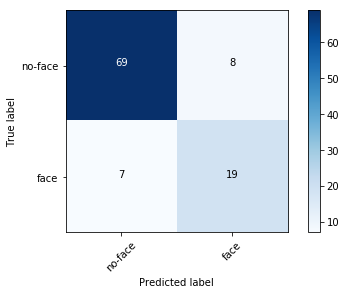

In [213]:
plot_cm(confusion_matrix(total['face'].as_matrix(), total['def'].as_matrix()))

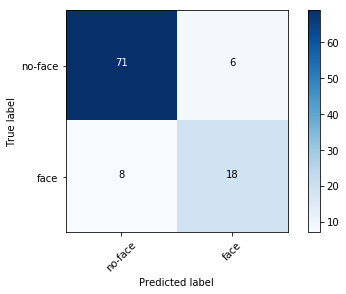

In [214]:
plot_cm(confusion_matrix(total['face'].as_matrix(), total['alt'].as_matrix()))

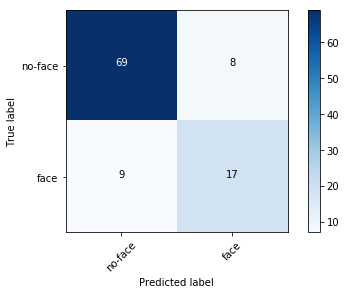

In [215]:
plot_cm(confusion_matrix(total['face'].as_matrix(), total['alt2'].as_matrix()))

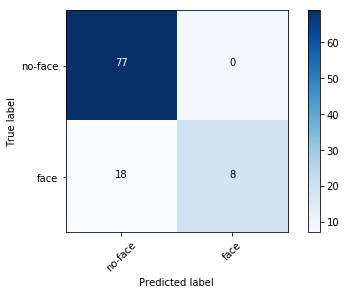

In [216]:
plot_cm(confusion_matrix(total['face'].as_matrix(), total['tree'].as_matrix()))

In [217]:
print(total.loc[total['tree'] == 1])

              username  face  def  alt  alt2  tree
10           arossgirl     1    1    1     1     1
41        jenniferbehr     1    1    1     1     1
48          loveassali     1    1    1     1     1
49  lovestory_official     1    1    1     1     1
73           samudra11     1    1    1     1     1
87         thelouloves     1    1    1     1     1
95        wearekindred     1    1    1     1     1
96       whitemontreal     1    1    1     1     1


In [226]:
files_in_folder = pd.DataFrame(columns=['filename', 'face'])
for root, dirs, files in os.walk(consumers_path):
        print(str(len(files)) + ' files were found at ' + consumers_path)
        for filename in files:
            files_in_folder = files_in_folder.append({'username': filename[:-4], 'face': 1}, ignore_index=True)
        break
files_in_folder.to_csv('consumers_files.csv')

433 files were found at /home/moreno/Documents/DataShack/dataswag/followers_classification/data/profile_pics/consumers/


In [13]:
consumers_tp = pd.read_csv('consumers_files.csv')
c_total = consumers_tp.merge(consumer_faces, on='username')
c_total['alt'] = c_total['alt'].apply(lambda x: int(x > 0))
c_total['alt2'] = c_total['alt2'].apply(lambda x: int(x > 0))
c_total['def'] = c_total['def'].apply(lambda x: int(x > 0))
c_total['tree'] = c_total['tree'].apply(lambda x: int(x > 0))
c_total

,username,face,def,alt,alt2,tree
0,___brookeb___,1,1,1,1,1
1,_flat_earth_,0,0,0,0,0
2,_g_romanova,1,0,0,0,0
3,_theresearcher_,1,0,0,0,0
4,abdeherrera,1,1,1,1,0
5,abelle1010,1,1,1,1,0
6,adenanohey7,1,1,0,0,0
7,adenylnatchelor,1,0,0,1,0
8,adva35,1,1,1,1,0
9,adyineadows,1,0,0,0,0
